In [1]:
import torch
import torch.nn as nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
noise = np.random.normal(0,1,2005) # U series
a_coeffs = np.array([-1,-1,-1,-1,5,1])# put in reverse order for easy implentation purpose

# Generating the series for Moving Average Models

In [ ]:
def generate_samples():
    
    noise = np.random.normal(0,1,2005)
    
    x_ = []
    y_ = []
    
    for i in range(5,2005):
        seq = noise[i-5:i+1]
        xt = sum(noise[i-5:i+1]*a_coeffs)
        x_.append(seq)
        y_.append(xt)

    x_ = torch.from_numpy(np.array(x_).transpose()).float()
    y_ = torch.from_numpy(np.array(y_)).float()

    x_ = x_.view([6,2000,-1])

    return noise, x_, y_

a_coeffs = np.array([-1,-1,-1,-1,5,1])
seq_len = 6

series_train, x_train, y_train = generate_samples()
series_test, x_test, y_test = generate_samples()

# Plotting the both Test and Train MV-Series

The sample values in the series are plotted over 2000 time-steps

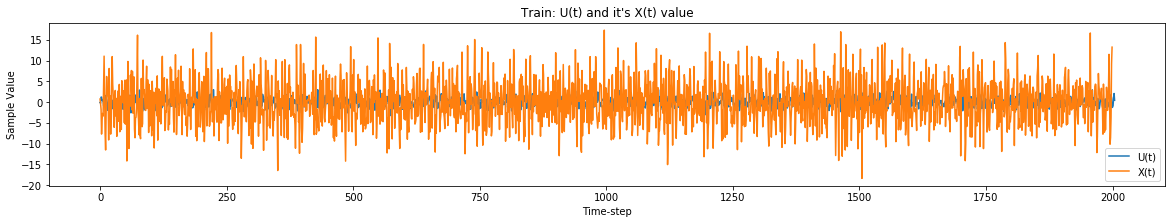

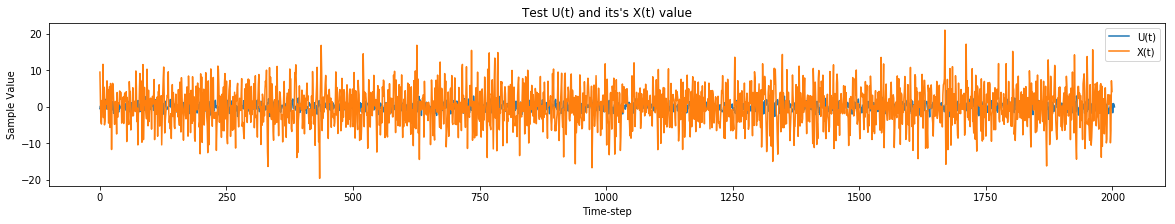

In [5]:
plt.rcParams["figure.figsize"] = (20,3)

plt.figure()
plt.xlabel("Time-step")
plt.ylabel("Sample Value")
plt.title("Train: U(t) and it's X(t) value")
plt.plot(series_train,label="U(t)")
plt.plot(y_train,label= "X(t)")
plt.legend()
plt.show()


plt.figure()
plt.xlabel("Time-step")
plt.ylabel("Sample Value")
plt.title("Test U(t) and its's X(t) value")
plt.plot(series_test,label="U(t)")
plt.plot(y_test,label= "X(t)")
plt.legend()
plt.show()

# Defining the RNN model structure

The model structure has 1 or 2 or 3 RNN layer(s) and then has a linear layer

The model takes a sequence of length 6 $(U_t$ to $U_{t-5})$ and predicts MV value $(X_t)$ element in the series. The window of length 6 is passed over the whole series $U$ to predict the all elements in the series $X$.

In [6]:
class MA_RNN(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, seq_len, batch_size, num_layers):
        super(MA_RNN, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size = input_dim,
                            hidden_size = hidden_dim,
                            num_layers = num_layers)
        self.linear = nn.Linear(in_features=hidden_dim, out_features=1)
        
    def reset_hidden_states(self):
        self.hidden = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)
        
    def forward(self, input):
       
        rnn_out, self.hidden = self.rnn(input)
               
        y_pred = self.linear(rnn_out[-1])
            
        return y_pred.view(-1)

# Training the RNN model

Number of epochs = 1000

Learning rate = 0.0001

Loss = Mean Square Error

Hidden State size = 50 (for all variations)

In [7]:
def train_model(model, train_data, train_labels):
    loss_fn  = nn.MSELoss()
    optimiser = optim.Adam(model.parameters(), lr = 1e-3)
    
    num_epochs = 1000
    
    train_hist = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        
        #model.reset_hidden_states()#comment out for stateless RNN
        
        y_pred = model(x_train)
        
        loss = loss_fn(y_pred, y_train)
        
        #if epoch %100 == 0:
            #print("Epoch and trainloss:", epoch,loss.item())
            
        train_hist[epoch] = loss.item()
        
        optimiser.zero_grad()
        
        loss.backward()
        
        optimiser.step()
        
    return model.eval(), train_hist

# Varying RNN Number of layers : 1, 2, 3

In [8]:
model1 = MA_RNN(1, 50, seq_len=seq_len,batch_size=2000, num_layers=1)
model1, train_hist1 = train_model(model1, x_train, y_train)

model2 = MA_RNN(1, 50, seq_len=seq_len,batch_size=2000, num_layers=2)
model2, train_hist2 = train_model(model2, x_train, y_train)

model3 = MA_RNN(1, 50, seq_len=seq_len,batch_size=2000, num_layers=3)
model3, train_hist3 = train_model(model3, x_train, y_train)

# Plotting Epoch- MSE curve for all variation

Initially, the error curves followed different trends for all variations but finally, all saturated.

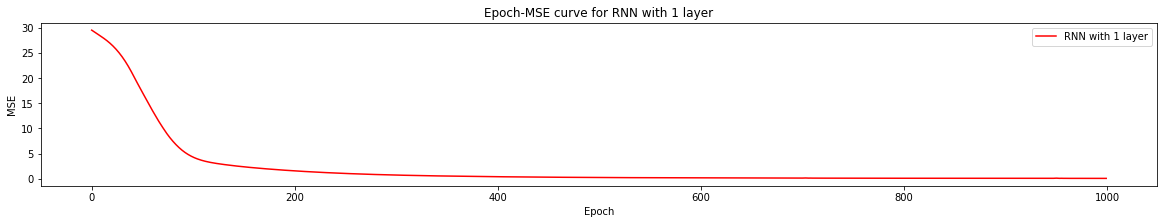

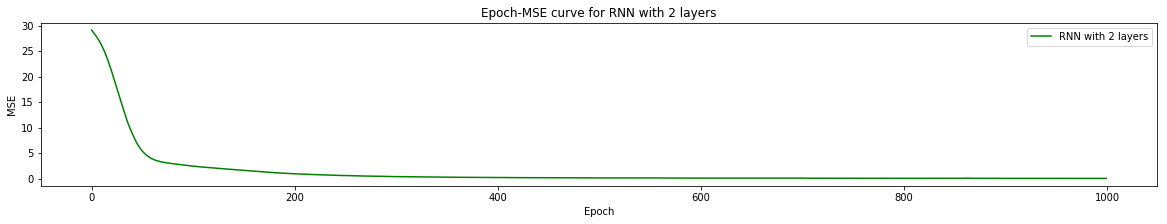

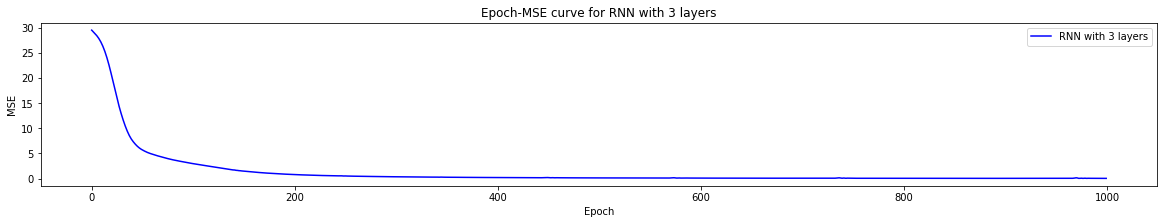

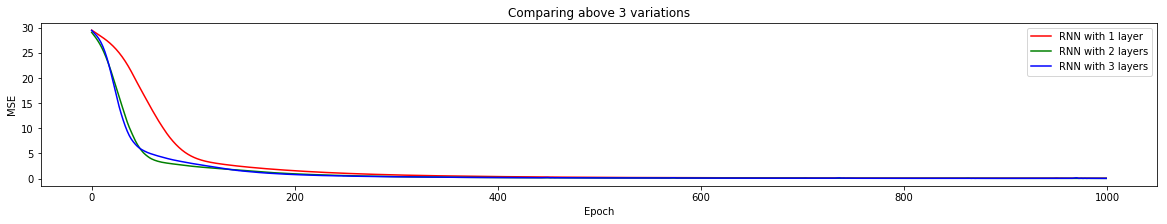

In [9]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Epoch-MSE curve for RNN with 1 layer')
plt.plot(train_hist1,color="red",label='RNN with 1 layer')
plt.legend()
plt.figure(2)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Epoch-MSE curve for RNN with 2 layers')
plt.plot(train_hist2,color="green",label='RNN with 2 layers')
plt.legend()
plt.figure(3)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Epoch-MSE curve for RNN with 3 layers')
plt.plot(train_hist3,color="blue",label='RNN with 3 layers')
plt.legend()
plt.figure(4)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Comparing above 3 variations')
plt.plot(train_hist1,color="red",label='RNN with 1 layer')
plt.plot(train_hist2,color="green",label='RNN with 2 layers')
plt.plot(train_hist3,color="blue",label='RNN with 3 layers')
plt.legend()
plt.show()

# Predictions for Test Data

In [10]:
with torch.no_grad():
    pred1 = torch.flatten(model1(x_test))
    pred2 = torch.flatten(model2(x_test))
    pred3 = torch.flatten(model3(x_test))

# Plotting Actual Test series and the Predicted Series for all variations

From the below plots, we can observe that for all the variations, the predicted series almost matches with the actual test series

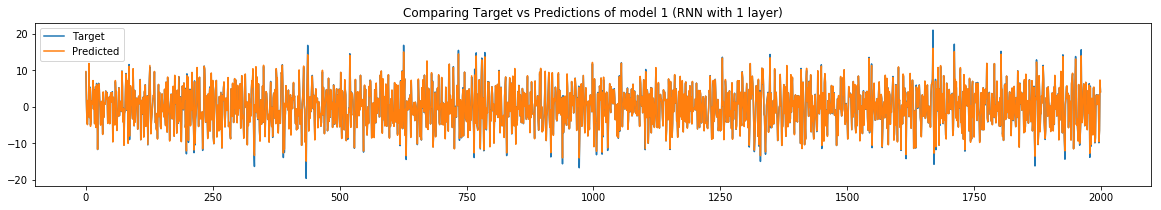

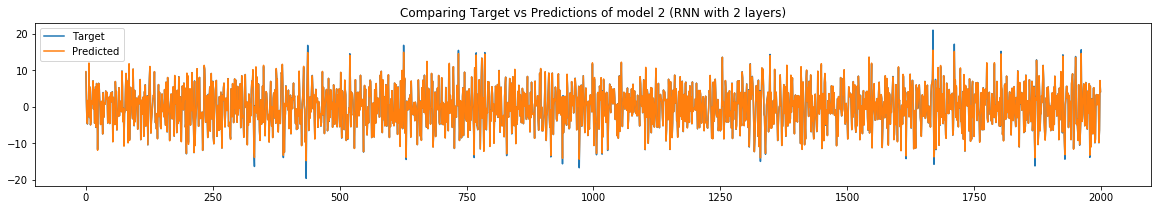

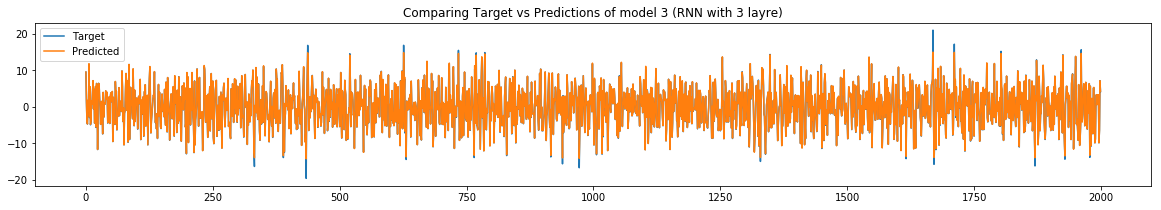

In [11]:
plt.figure()
plt.title("Comparing Target vs Predictions of model 1 (RNN with 1 layer)")
plt.plot(y_test,label="Target")
plt.plot(pred1,label="Predicted")
plt.legend()
plt.show()

plt.figure()
plt.title("Comparing Target vs Predictions of model 2 (RNN with 2 layers)")
plt.plot(y_test,label="Target")
plt.plot(pred2,label="Predicted")
plt.legend()
plt.show()

plt.figure()
plt.title("Comparing Target vs Predictions of model 3 (RNN with 3 layre)")
plt.plot(y_test,label="Target")
plt.plot(pred3,label="Predicted")
plt.legend()
plt.show()

# Defining the Losses: MSE, MAE, R2

In [12]:
y_test = torch.flatten(y_test)

mse = torch.nn.MSELoss()
mae = torch.nn.L1Loss()   

x = mae(pred1,y_test)

def r2score(target, pred):
    mean = torch.mean(target)
    sstot = torch.sum((target-mean)**2)
    ssres = torch.sum((target-pred)**2)
    r2score = 1-(ssres/sstot)
    return r2score

# Reporting the MSE, MAE and R2 Score for all variations

All the variations (#layers = 1,2,3) shown approximately the same errors. Comparitively the RNN-with 1 layer performed poorer than others

In [15]:
print("Number of layers = 1 : MSE = %s, MAE = %s, R2score = %s"
      %(np.array(mse(pred1,y_test)),np.array(mae(pred1,y_test)),np.array(r2score(pred1,y_test))))
print("Number of layers = 2 : MSE = %s, MAE = %s, R2score = %s"
      %(np.array(mse(pred2,y_test)),np.array(mae(pred2,y_test)),np.array(r2score(pred2,y_test))))
print("Number of layers = 3 : MSE = %s, MAE = %s, R2score = %s"
      %(np.array(mse(pred3,y_test)),np.array(mae(pred3,y_test)),np.array(r2score(pred3,y_test))))

Number of layers = 1 : MSE = 0.10563127, MAE = 0.153771, R2score = 0.99628305
Number of layers = 2 : MSE = 0.05716082, MAE = 0.07307598, R2score = 0.99800754
Number of layers = 3 : MSE = 0.062638104, MAE = 0.084693246, R2score = 0.9978085
